c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'burgers_33', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


iter= 0 , loss= 0.17844988
iter= 1 , loss= 0.15962021
iter= 2 , loss= 0.15159726
iter= 3 , loss= 0.14859264
iter= 4 , loss= 0.1481802
iter= 5 , loss= 0.14964345
iter= 6 , loss= 0.15181358
iter= 7 , loss= 0.1529513
iter= 8 , loss= 0.15247366
iter= 9 , loss= 0.15101281
iter= 10 , loss= 0.14936279
iter= 11 , loss= 0.14796466
iter= 12 , loss= 0.14693959
iter= 13 , loss= 0.14627458
iter= 14 , loss= 0.145944
iter= 15 , loss= 0.14591905
iter= 16 , loss= 0.14612442
iter= 17 , loss= 0.14641678
iter= 18 , loss= 0.14662285
iter= 19 , loss= 0.14661711
iter= 20 , loss= 0.14637159
iter= 21 , loss= 0.14594655
iter= 22 , loss= 0.14544293
iter= 23 , loss= 0.1449515
iter= 24 , loss= 0.14452855
iter= 25 , loss= 0.14419883
iter= 26 , loss= 0.14396484
iter= 27 , loss= 0.14381161
iter= 28 , loss= 0.14370738
iter= 29 , loss= 0.14360678
iter= 30 , loss= 0.14346293
iter= 31 , loss= 0.14324206
iter= 32 , loss= 0.14293227
iter= 33 , loss= 0.14254436
iter= 34 , loss= 0.14210586
iter= 35 , loss= 0.14164895
iter= 3

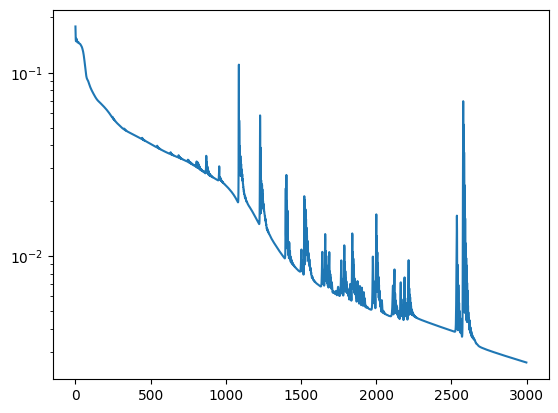

In [ ]:
#목표: 버거스 방정식의 해를 pinn이용해서 구하기
#fit 메서드를 당연히 사용하지않는다 => 기존과 다른 학습방식을 사용하므로! (자체적인 모델링이 required)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

class Burgers(Model):             #인공신경망을 정의하는 클래스(즉 함수(해)를 정의해주는거니 이름을 burgers라고 붙임)

    def __init__(self):  #__init__은 내장모듈로써 초기화함수. __init__은 객체가 인스턴스화 될때 자동으로 실행되므로 클래스에 필요한 초기설정을 여기서함.
        super(Burgers, self).__init__()
#여기서는 NN의 각 레이어를 정의해준다
        self.h1 = Dense(20, activation='tanh')
        self.h2 = Dense(20, activation='tanh')
        self.h3 = Dense(20, activation='tanh')
        self.h4 = Dense(20, activation='tanh')
        self.h5 = Dense(20, activation='tanh')
        self.h6 = Dense(20, activation='tanh')
        self.u = Dense(1, activation='linear') #출력값은 그대로 전달 해줘야 하므로 linear을 활성화 함수로 써준다.


    def call(self, state): #참고로 tf는 call라는 이름의 메소드가 있으면 이를 자동으로 순전파 메서드로 인식함
        #여기서는 NN의 순전파 과정을 구현
        x = self.h1(state)
        x = self.h2(x)
        x = self.h3(x)
        x = self.h4(x)
        x = self.h5(x)
        x = self.h6(x)
        out = self.u(x)
        return out


class Pinn(object): #실제로 인공신경망 연산이 이뤄지는건 pinn 모델이니까 이름을 pinn이라 붙인것

    def __init__(self):
    #여기선 optimizer와 NN을 초기화해줌
        self.lr = 0.001   #lr은 learning rate : 학습률 (경사하강법의 하이퍼파라미터)
        self.opt = Adam(self.lr)

        self.burgers = Burgers()
        self.burgers.build(input_shape=(None, 2))

    def physics_net(self, xt): #논문의 f를 만드는 과정같음
        x = xt[:, 0:1]
        t = xt[:, 1:2]

        with tf.GradientTape(persistent=True) as tape: #persistent=True인 이유는 tape가 원래 한번 미분하면 사라지므로 이계미분을 위해서..
            tape.watch(t)
            tape.watch(x)
            xt_t = tf.concat([x,t], axis=1)
            u = self.burgers(xt_t)
            u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
        u_t = tape.gradient(u, t)
        del tape

        return u_t + u*u_x - (0.01/np.pi)*u_xx #콜로케이션 포인트들에서의 f의 값을 반환한다.


    def save_weights(self, path):
        self.burgers.save_weights(path + 'burgers.weights.h5')



    def load_weights(self, path):
        self.burgers.load_weights(path + 'burgers.weights.h5')


    def learn(self, xt_col, xt_bnd, tu_bnd): #손실함수를 계산하고, 역전파를 구현하는 메서드
        with tf.GradientTape() as tape:
            f = self.physics_net(xt_col)
            loss_col = tf.reduce_mean(tf.square(f)) #MSE_f, 즉 pde의 residual과 pde의 우변의 오차함수

            tu_bnd_hat = self.burgers(xt_bnd)
            loss_bnd = tf.reduce_mean(tf.square(tu_bnd_hat-tu_bnd)) #MSE_u 즉 경계조건(& 초기조건)과 실제 구한 u가 얼마나 차이나는지의 오차함수

            loss = loss_col + loss_bnd #MSE =MSE_f + MSE_u

        grads = tape.gradient(loss, self.burgers.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.burgers.trainable_variables))  #여기가 역전파 과정

        return loss


    def predict(self, xt):   #입출력함수
        tu = self.burgers(xt)
        return tu


    def train(self, max_num): #데이터 셋 주고, 실제로 train 하는 메서드 

        # initial and boundary condition
        x_data = np.linspace(-1.0, 1.0, 500)
        t_data = np.linspace(0.0, 1.0, 500)
        xt_bnd_data = []
        tu_bnd_data = []

        for x in x_data:
            xt_bnd_data.append([x, 0])
            tu_bnd_data.append([-np.sin(np.pi * x)])

        for t in t_data:
            xt_bnd_data.append([1, t])
            tu_bnd_data.append([0])
            xt_bnd_data.append([-1, t])
            tu_bnd_data.append([0])
            #경계, 초기 조건을 만족하는 데이터들이 500개씩 만들어지짐.
        xt_bnd_data = np.array(xt_bnd_data)
        tu_bnd_data = np.array(tu_bnd_data)

        # collocation point
        t_col_data = np.random.uniform(0, 1, [20000, 1])  #20000개의 콜로케이션 포인트 데이터 생성
        x_col_data = np.random.uniform(-1, 1, [20000, 1])
        xt_col_data = np.concatenate([x_col_data, t_col_data], axis=1) #콜로케이션 포인트 셋 완성
        xt_col_data = np.concatenate((xt_col_data, xt_bnd_data), axis=0)#bnd 포인트와 col 포인트 셋 합치기

        train_loss_history = []

        for iter in range(int(max_num)): #주어진 반복횟수 만큼 iter

            loss = self.learn(tf.convert_to_tensor(xt_col_data, dtype=tf.float32), #learn으로 MSE 구하기
                        tf.convert_to_tensor(xt_bnd_data, dtype=tf.float32),
                        tf.convert_to_tensor(tu_bnd_data, dtype=tf.float32))

            train_loss_history.append([iter, loss.numpy()])

            print('iter=', iter, ', loss=', loss.numpy())

        self.save_weights("./save_weights/")  #최종 결과를 저장

        np.savetxt('./save_weights/loss.txt', train_loss_history)
        train_loss_history = np.array(train_loss_history)

        plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
        plt.yscale("log")
        plt.show()


def main():

    max_num = 3000
    agent = Pinn()

    agent.train(max_num)


if __name__=="__main__":
    main()

iteration에 따른 loss의 그래프

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'burgers_34', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


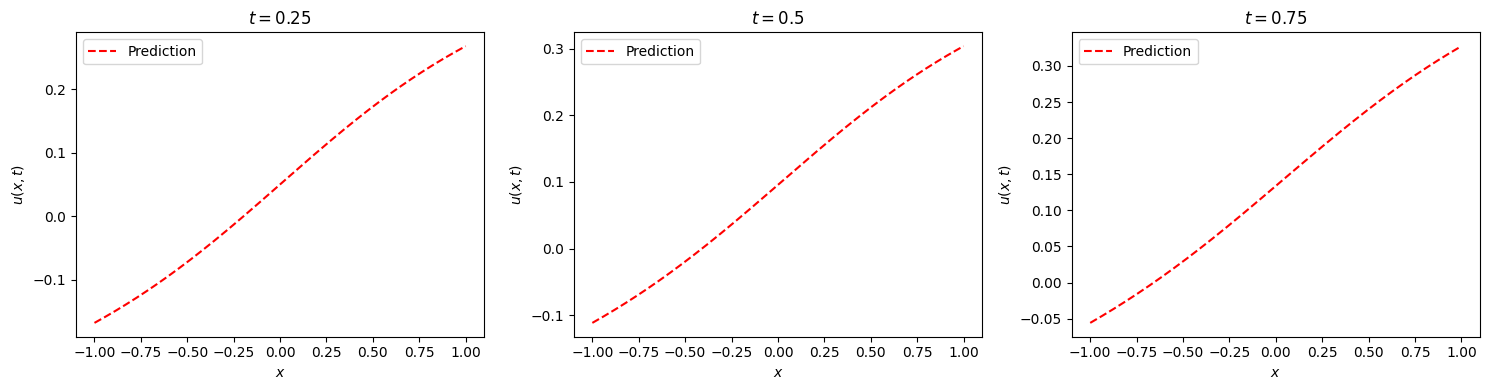

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 고정된 t 값들
t_values = [0.25, 0.5, 0.75]
x_values = np.linspace(-1, 1, 500)

# PINN 모델 초기화 및 가중치 로드
agent = Pinn()  # Pinn 모델 초기화
agent.load_weights("./save_weights/")  # 저장된 가중치 로드

plt.figure(figsize=(15, 4))  # 플롯 크기 설정

for i, fixed_t in enumerate(t_values, 1):
    # t가 고정된 상태에서 x 값에 따른 (x, t) 데이터 생성
    xt_values = np.array([[x, fixed_t] for x in x_values], dtype=np.float32)
    
    # 예측 수행
    predicted_u = agent.predict(tf.convert_to_tensor(xt_values))
    predicted_u = predicted_u.numpy().flatten()  # 1D 배열로 변환
    
    # 그래프 그리기
    plt.subplot(1, len(t_values), i)
    plt.plot(x_values, predicted_u, 'r--', label="Prediction")
    plt.xlabel(r'$x$')
    plt.ylabel(r'$u(x, t)$')
    plt.title(r'$t = {}$'.format(fixed_t))
    plt.legend()

plt.tight_layout()
plt.show()
